<a href="https://colab.research.google.com/github/Alexher90/An-lisis-de-Datos-2/blob/master/Solucion_Semana16_AprendizajePorRefuerzo_Actividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Aprendizaje por Refuerzo


### Profesor asistente: Diego Gomez (df.gomez11@uniandes.edu.co)

En este cuaderno implementaremos un par de métodos de Aprendizaje por Refuerzo.

Utilizaremos nuestros algoritmos para intentar maximizar nuetra probabilidad de ganar en el juego de cartas Blackjack.


---


*A lo largo del ejercicio encontrará la palabra `TODO`. Esto le indica que hay una línea de código por completar.


---



**Presentado por: Alexander Hernández Páez (200920588), Alexander Camargo (200911325), Juan David Cortés (201728568), Wilson Felipe González (200924943).**

Primero importeremos los paquetes necesarios. En el archivo adicional .py se encuentra el ambiente `BlackJackEnv`, que nos servirá para simlar el juego de Blackjack.

In [ ]:
import numpy as np
import random

from blackjack_utils import BlackJackEnv as AmbienteBJ
from blackjack_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

semilla = 0
np.random.seed(semilla)

La clase `BlackJackEnv` tiene 2 métodos de nuestro interés:


1.   `reset`
2.   `step`  

El método `reset` inicializa el juego y se reparten las manos del jugador y del dealer. El método `step` recibe como argumento una acción y ejecuta la transición correspondiente. Las acciones posibles son 0 y 1, donde 0 corresponde a **Plantarse** y 1 corresponde a **Pedir** una nueva carta. Este método retorna 4 elementos: el estado actual, es decir, la mano del jugador y la carta del repartidor visible, el siguiente estado al tomar la acción, la recompensa obtenida y una señal que indica si ej juego terminó. La recompensa será 0 si el juego no ha terminado o hay un empate, 1 si el jugador gana y -1 si el jugador pierde.

En el área de Aprendizaje por Refuerzo es común utilizar librerías que nos proveen con múltiples ambientes. Estos ambientes usualmente tienen los mismos dos métodos que se mencionan acá.

Generemos el ambiente y juguemos un par de manos.

In [ ]:
juego = AmbienteBJ(seed=semilla)
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)

Mano inicial:  [[('7', 'clubs'), ('3', 'spades')], ('J', 'diamonds')]


In [ ]:
mano, siguiente_mano, recompensa, juego_terminado = juego.step(0) # Nos plantaremos
print('Nueva mano: ', siguiente_mano)
print('Recompensa: ', recompensa)
print('Juego terminado: ', juego_terminado)

Nueva mano:  [[('7', 'clubs'), ('3', 'spades')], [('10', 'diamonds'), ('J', 'diamonds')]]
Recompensa:  -1.0
Juego terminado:  True


In [ ]:
mano_inicial = juego.reset()
print('Mano inicial: ', mano_inicial)

Mano inicial:  [[('Q', 'clubs'), ('J', 'clubs')], ('K', 'hearts')]


In [ ]:
mano, siguiente_mano, recompensa, juego_terminado = juego.step(1) # Pediremos una nueva carta
print('Nueva mano: ', siguiente_mano)
print('Recompensa: ', recompensa)
print('Juego terminado: ', juego_terminado)

Nueva mano:  [[('5', 'clubs'), ('Q', 'clubs'), ('J', 'clubs')], [('8', 'clubs'), ('K', 'hearts')]]
Recompensa:  -1.0
Juego terminado:  True


## Definición del Agente

### Ejercicio 1

Definiremos ahora la clase `Agente`. Esta clase tendrá un atributo de interés y 4 distintos métodos. El atributo corresponde la función de valor q, que es una matriz de tamaño 10x10x2x2 y donde las primeras 3 dimensiones corresponden al estado y la última a la acción. Tendrán que completar los distintos métodos, cuyas descripciones se encuentran justo antes de cada método.

In [ ]:
class Agente():
  def __init__(self, dim_estado=(10,10,2), dim_accion=(2,)):    
    self.funcion_q = np.zeros(dim_estado+dim_accion) # Funcion de valor Q
    self.n_acciones = dim_accion[0]

  '''
  Metodo 1:
  Este metodo transforma la mano del jugador y la carta del dealer
  a nuestra representacion de estado. 
  Argumentos:
    - estado: tupla donde el primer elemento es una lista de cartas, 
              correspondientes a la mano del jugador, y donde el segundo 
              elemento es la carta visible del dealer
  Salida:
    - estado transformado: tupla de 3 elementos (s_0, s_1, s_2), donde:
              s_0:  indical el puntaje del jugador. Es un numero de 0 a 9, que 
                    corresponde a una suma de 12 a 21, en el mismo orden.
              s_1:  indica la mano del dealer. Es un numero de 0 a 9, que corresponde
                    al valor de la carta del dealer entre 1 y 10, en el mismo orden.
              s_2:  indica si el as es utilizable. Es un número entre 0 y 1, que
                    corresponde a si el As se puede o no utilizar como 11.                
  '''
  def transformar_estado(self, estado):
    suma_mano, puntaje_dealer, as_utilizable = state2code(estado)
    puntaje = suma_mano + 10*as_utilizable      
    if puntaje < 12:
      s_0 = s_1 = s_2 = None
    else:      
      s_0 = int(puntaje-12)        
      s_1 = int(puntaje_dealer-1)  
      s_2 = int(as_utilizable)
    estado_transformado = (s_0, s_1, s_2)   
    return estado_transformado


  '''
  Metodo 2:
  Este metodo genera una accion para sumas entre 12 y 21, siguiendo una politica
  epsilon-suave.
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - epsilon:  valor entre 0 y 1, que corresponde al factor de exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def generar_accion_con_politica_epsilon_suave(self, estado_transformado, epsilon):
    s_0, s_1, s_2 = estado_transformado
    valores_q = self.funcion_q[s_0, s_1, s_2, :]
    if np.random.rand() > epsilon: # TODO
      acciones_posibles = valores_q.argmax()
      if isinstance(acciones_posibles, np.int64):
        accion = acciones_posibles
      else:
        accion = random.choice(acciones_posibles)
    else:
      accion = np.random.randint(0, high=self.n_acciones) # TODO
    return accion
  

  '''
  Metodo 3:
  Este metodo selecciona una accion para cualquier estado.
  Argumentos: 
    - estado:   tupla donde el primer elemento es una lista de cartas, 
                correspondientes a la mano del jugador, y donde el segundo 
                elemento es la carta visible del dealer
    - epsilon:  valor real positivo entre 0 y 1, que corresponde al factor de 
                exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def seleccionar_accion(self, estado, epsilon):
    estado_transformado = self.transformar_estado(estado)
    suma_menor_12 = estado_transformado[0] is not None
    if suma_menor_12:
      accion = self.generar_accion_con_politica_epsilon_suave(estado_transformado, epsilon) # TODO
    else:
      accion = 1
    return accion, estado_transformado

  
  '''
  Metodo 4:
  Este metodo actualiza los valores de la funcion q para una pareja (estado-accion),
  adicionandole una cantidad específica 
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
    - cambio:   valor real que determina que tanto cambia la funcion q
    - alpha:    valor real positivo entre 0 y 1, que corresponde a la tasa de aprendizaje
  '''
  def actualizar_funcion_q(self, estado_transformado, accion, cambio, alpha):
    indice_pareja_estado_accion = estado_transformado + (accion,)
    self.funcion_q[indice_pareja_estado_accion] += alpha * cambio

Creemos a un agente y generemos una acción, para observar su comportamiento.

In [ ]:
mano_inicial = juego.reset()
agente = Agente()
accion, estado_transformado = agente.seleccionar_accion(mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Estado: ', estado_transformado)
print('Accion tomada: '+str(accion))

Mano:  [[('6', 'spades'), ('2', 'hearts')], ('A', 'spades')]
Estado:  (None, None, None)
Accion tomada: 1


## Método de Monte Carlo

### Ejercicio 2.1
Definiremos un método para que el agente interactue con el ambiente por un instante de tiempo.

In [ ]:
def dar_paso(juego, agente, estado, epsilon):
  # El agente selecciona una accion
  accion, estado_transformado = agente.seleccionar_accion(estado, epsilon)# TODO

  # El agente actua en el ambiente y recibe la informacion del nuevo estado,
  # la recompensa y la señal de juego terminado
  _, siguiente_estado, recompensa, juego_terminado = juego.step(accion) # TODO
  # Se crea una lista con la informacion del paso dado
  paso = [estado_transformado, accion, recompensa, juego_terminado]
          
  return paso, siguiente_estado.copy(), juego_terminado 

Daremos un paso, para probar el método que acabamos de definir.

In [ ]:
mano_inicial = juego.reset()
paso, siguiente_mano, juego_terminado = dar_paso(juego, agente, mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Siguiente mano: ', siguiente_mano)
print('Juego terminado: ', juego_terminado)

Mano:  [[('A', 'clubs'), ('4', 'spades')], ('J', 'diamonds')]
Siguiente mano:  [[('A', 'clubs'), ('4', 'spades'), ('6', 'diamonds')], ('J', 'diamonds')]
Juego terminado:  False


### Ejercicio 2.2
Definiremos un método para que el agente juegue un juego completo y retorne una trayectoria correspondiente a este juego.

In [ ]:
def generar_trayectoria(juego, agente, epsilon):
  juego_terminado = False    
  trayectoria = []
  estado = juego.reset()

  # Ciclo que genera una trayectoria. En este caso, corresponde a un juego 
  # completo de Blackjack. 
  while not juego_terminado:   
    # Se da un paso
    paso, siguiente_estado, juego_terminado = dar_paso(juego, agente, estado, epsilon) # TODO

    # Se agrega el paso a la trayectoria
    trayectoria.append(paso)    

    # Se actualiza la información del estado  
    estado = siguiente_estado.copy()

  return trayectoria  

Juguemos un juego completo a partir del metodo que acabamos de definir.

In [ ]:
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Trayectoria:")
print(trayectoria)

Trayectoria:
[[(4, 7, 0), 0, 1.0, True]]


### Ejercicio 2.3
Definiremos un método para que el agente actualice su función q para el último paso de la trayectoria que no ha sido incluido.

In [ ]:
def actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha, beta):
    # Se extrae el ultimo paso de la trayectoria que no ha sido incluido
    estado, accion, recompensa, juego_terminado = paso

    # Se actualiza el retorno como la suma de la recompensa mas el acumulado futuro
    retorno = recompensa+beta*retorno # TODO

    # Se actualiza la funcion q del agente si la suma es mayor a 12
    suma_mayor_12 = estado[0] is not None
    if suma_mayor_12:
      indice_estado_accion = estado + (accion,) 
      cambio_funcion_q = retorno - agente.funcion_q[indice_estado_accion]       
      agente.actualizar_funcion_q(estado, accion, cambio_funcion_q, alpha)
    
    return retorno

Veamos cómo cambia la función q cuando utilizamos el método.

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = 0.0
paso = trayectoria[-1]
print("Retorno (antes de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
retorno = actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha=0.1, beta=1.0)
print("Retorno (despues de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Retorno (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Retorno (despues de la actualizacion):  -1.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


Podemos ver que inicialmente la función q está completamente llena de valores 0, mientras que después de la actualización no.

### Ejercicio 2.4
Definiremos un método para que el agente actualice su función q a partir de una trayectoria

In [ ]:
def actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta):
    # Inicializamos el retorno
    retorno = 0

    # Recorremos la trayectoria desde el final hasta el comienzo para estimar el
    # retorno para cada pareja estado-accion
    for indice_ultimo_paso in range(len(trayectoria)-1,-1,-1):
      # Obtenemos un paso de la trayectoria
      ultimo_paso = trayectoria[indice_ultimo_paso]

      # Actalizamos el retorno para el paso y el valor q correspondiente
      retorno = actualizar_retorno_y_funcion_q_con_paso(agente, ultimo_paso, retorno, alpha, beta) # TODO

Repetimos el procedimiento del Ejercicio 2.3, pero ahora para una trayectoria completa. 

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha=0.1, beta=1.0)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


### Ejercicio 2.5
Habiendo definido los métodos para generar trayectorias y actualizar la función q a partir de estas, ya podemos definir nuestro método de entrenamiento de Monte Carlo.

In [ ]:
def entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000):  
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO
    
    # Actualizamos la funcion q
    actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta) # TODO  
      
    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

## Bloque de entrenamiento

Antes de probar nuestro método de Monte Carlo, vamos a definir una función que nos permitirá evaluar el desempeño del agente y de esta manera podremos saber si nuestro método lo mejora.

### Ejercicio 3.1
Primero, definamos un método que calcule el retorno de una trayectoria.

In [ ]:
def calcular_retorno_trayectoria(trayectoria, beta):
  # Inicializamos el valor del retorno
  retorno = 0.0

  # Iteramos, paso por paso, y vamos sumando la recompensa de cada paso,
  # teniendo en cuenta el factor de descuento
  for t, paso in enumerate(trayectoria):
    # Obtenemos la recompensa
    recompensa = paso[2]

    # Actualizamos el retorno
    retorno += (beta**t) * recompensa # TODO
    
  return retorno

Probemos que el método funcione en una trayectoria. 

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = calcular_retorno_trayectoria(trayectoria, beta=1.0)
print("Trayectoria: ", trayectoria)
print("Retorno: ", retorno)

Trayectoria:  [[(8, 4, 0), 0, 1.0, True]]
Retorno:  1.0


### Ejercicio 3.2
Ahora sí definamos el método que evalua el desempeño del agente, calculando el retorno promedio en una cantidad especificada de episodios, así como su desviación estándar. 

In [ ]:
def evaluar_agente(juego, agente, n_episodios, epsilon, beta,
                   imprimir=False, ciclo=0):
  retornos = []
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO

    # Calculamos el retorno
    retorno = calcular_retorno_trayectoria(trayectoria, beta) # TODO
      
    # Añadimos el retorno a una lista de retornos
    retornos.append(retorno)
  
  # Calculamos el retorno promedio y su desviacion
  retornos = np.array(retornos)
  retorno_promedio = retornos.mean()
  desviacion_retorno = retornos.std()

  # Imprimimos el retorno si es necesario
  if imprimir:
    print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
  return retorno_promedio, desviacion_retorno

Una vez contamos con la forma de evaluar al agente, podemos observar si nuestro algoritmo de Monte Carlo tiene un efecto positivo o no.

In [ ]:
agente = Agente()
retorno_antes = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
entrenar_agente_MonteCarlo(juego, agente, alpha=0.001, beta=1.0, epsilon=1.0, n_episodios=100000)
retorno_despues = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
print("Retorno antes de entrenar: ", retorno_antes)
print("Retorno despues de entrenar: ", retorno_despues)

Retorno antes de entrenar:  (-0.3816, 0.8999896888298221)
Retorno despues de entrenar:  (-0.3976, 0.8906818960773817)


Dependiendo de la semilla, puede que el retorno después del entrenamiento sea más bajo. Esto es común en aprendizaje por refuerzo, cuando la variación es bastante alta. Sin embargo, una vez se utiliza la cantidad suficiente de episodios, lograremos ver el progreso del agente.

### Ejercicio 3.3
Nuestro último método consistirá en un bloque de entrenamiento en el que se alterna el aprendizaje del agente y su evaluación. La salida del método es una lista con la evolución del desempeño del agente.

In [ ]:
def entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                    n_ciclos, n_episodios_ent, n_episodios_eval):
  # Se crean listas de desempeño
  retornos_media = []
  retornos_desviacion = []

  # Se ejecuta ciclo de entrenamiento y evaluacion una cantidad n_ciclos de veces
  for ciclo in range(0, n_ciclos):
    # Se entrena al agente
    entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios_ent) # TODO

    # Se evalua al agente
    G_promedio, G_desviacion = evaluar_agente(juego, agente, n_episodios_eval, epsilon, beta, imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1) # TODO
                              
    
    # Guardamos el desempeño del agente
    retornos_media.append(G_promedio)
    retornos_desviacion.append(G_desviacion)

    epsilon = max(min_epsilon, epsilon * decaimiento_epsilon)

  return retornos_media, retornos_desviacion

## Entrenamiento y gráficas

Definamos los hiperparametros necesarios y ejecutemos nuestro bloque de entramiento.

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo = entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.403±0.887
Ciclo: 21, Retorno esperado: -0.152±0.952
Ciclo: 41, Retorno esperado: -0.083±0.956
Ciclo: 61, Retorno esperado: -0.059±0.954
Ciclo: 81, Retorno esperado: -0.035±0.953
Ciclo: 101, Retorno esperado: -0.043±0.954
Ciclo: 121, Retorno esperado: -0.044±0.953
Ciclo: 141, Retorno esperado: -0.038±0.952
Ciclo: 161, Retorno esperado: -0.051±0.953
Ciclo: 181, Retorno esperado: -0.044±0.954


In [ ]:
# # Este bloque sirve para guardar y cargar el agente
# import pickle

# Para guardar
# pickle.dump(agente, open('agente_MC.pt', 'wb'))

# Para cargar
# agente = pickle.load(open('agente_MC.pt', 'rb'))

Ahora grafiquemos la curva de aprendizaje para determinar si sí hubo aprendizaje y si la cantidad de episodios fue suficiente.

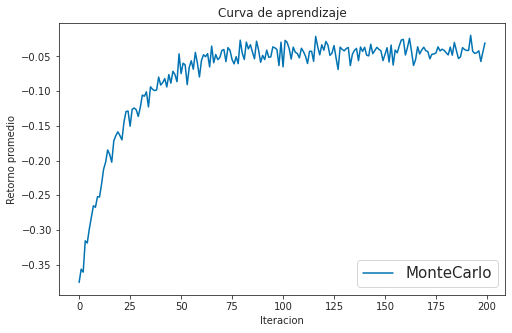

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo[0]), label='MonteCarlo')
plt.title('Curva de aprendizaje')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

Por último, grafiquemos la política óptima.

In [ ]:
politica_optima = agente.funcion_q.argmax(3)
politica_optima_df_dic = {}
for i in range(0,2):
  politica_optima_df_dic[str(i)] = pd.DataFrame(data=politica_optima[:,:,i], 
                                       index=range(12,22), 
                                       columns=['A']+[str(x) for x in range(2,11)])

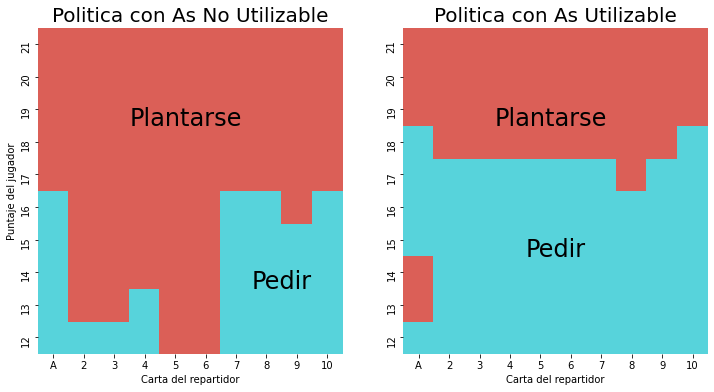

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
for i in range(0,2):
  sns_ax = sns.heatmap(politica_optima_df_dic[str(i)], ax=ax[i], 
                       cmap=sns.color_palette("hls", 2), cbar=False)
  sns_ax.invert_yaxis()
  ax[i].set_xlabel('Carta del repartidor')
ax[0].text(7.0, 2.0, 'Pedir', fontsize=24)
ax[0].text(3.0, 7.0, 'Plantarse', fontsize=24)
ax[1].text(4.0, 3.0, 'Pedir', fontsize=24)
ax[1].text(3.0, 7.0, 'Plantarse', fontsize=24)
ax[0].set_title('Politica con As No Utilizable', fontsize=20)
ax[1].set_title('Politica con As Utilizable', fontsize=20)
ax[0].set_ylabel('Puntaje del jugador')
plt.show()
plt.close()

# Preguntas

1.   ¿Cuál es el efecto del parámetro epsilon en la curva de aprendizaje?¿Por qué? Pruebe 3 distintos valores y compáre los resultados en una gráfica.
2.   El algoritmo que se está implementando no es exactamente igual al explicado en el video. Describa las diferencias e intente explicar por qué son necesarias. (Hint: acá se introduce un parámetro $\alpha$ que no se encuentra en el algoritmo original. ¿Qué papel está cumpliendo? La estimación de la función q supone que la política es invariante. ¿Esto se cumple?¿Por qué?) 
3.   En este caso tenemos 200 estados, ¿cree que el método puede ser tan útil para un ambiente con 2000 estados?, ¿y para uno de 2 millones?, ¿y qué pasa si el espacio de estados es continuo?¿Cómo cree que se puede atacar este problema?
4.   ¿Cree que es viable utilizar el método de programación dinámica en este problema?¿Por qué sí o por qué no?
4.   Bono: Implemente el algoritmo Q-learning o el algoritmo SARSA y haga una comparación.

##Primer punto:

**Con epsilon1 = 0.4:**

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon1 = 0.4
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo1 = entrenar_agente(juego, agente, alpha, beta, epsilon1, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.185±0.949
Ciclo: 21, Retorno esperado: -0.105±0.955
Ciclo: 41, Retorno esperado: -0.079±0.955
Ciclo: 61, Retorno esperado: -0.049±0.956
Ciclo: 81, Retorno esperado: -0.040±0.953
Ciclo: 101, Retorno esperado: -0.060±0.954
Ciclo: 121, Retorno esperado: -0.042±0.952
Ciclo: 141, Retorno esperado: -0.039±0.954
Ciclo: 161, Retorno esperado: -0.048±0.955
Ciclo: 181, Retorno esperado: -0.040±0.952


**Con epsilon2 = 0.1**

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon2 = 0.1
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo2 = entrenar_agente(juego, agente, alpha, beta, epsilon2, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.088±0.955
Ciclo: 21, Retorno esperado: -0.077±0.958
Ciclo: 41, Retorno esperado: -0.069±0.954
Ciclo: 61, Retorno esperado: -0.039±0.955
Ciclo: 81, Retorno esperado: -0.045±0.953
Ciclo: 101, Retorno esperado: -0.067±0.953
Ciclo: 121, Retorno esperado: -0.051±0.951
Ciclo: 141, Retorno esperado: -0.035±0.954
Ciclo: 161, Retorno esperado: -0.045±0.954
Ciclo: 181, Retorno esperado: -0.047±0.953


**Con Epsilon3 = 0.8**

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon3 = 0.8
min_epsilon3 = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo3 = entrenar_agente(juego, agente, alpha, beta, epsilon3, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.301±0.926
Ciclo: 21, Retorno esperado: -0.131±0.954
Ciclo: 41, Retorno esperado: -0.080±0.959
Ciclo: 61, Retorno esperado: -0.049±0.956
Ciclo: 81, Retorno esperado: -0.039±0.953
Ciclo: 101, Retorno esperado: -0.043±0.954
Ciclo: 121, Retorno esperado: -0.034±0.953
Ciclo: 141, Retorno esperado: -0.036±0.955
Ciclo: 161, Retorno esperado: -0.048±0.953
Ciclo: 181, Retorno esperado: -0.046±0.952


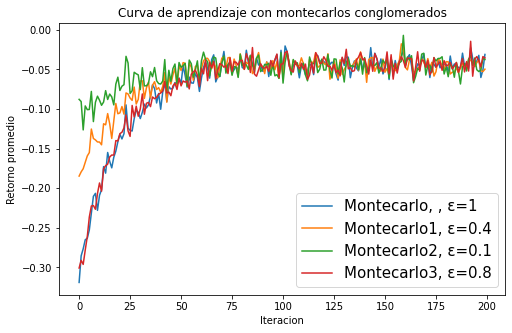

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo[0]), label = 'Montecarlo, , ε=1')
plt.plot(np.array(retornos_MonteCarlo1[0]), label = 'Montecarlo1, ε=0.4')
plt.plot(np.array(retornos_MonteCarlo2[0]), label = 'Montecarlo2, ε=0.1')
plt.plot(np.array(retornos_MonteCarlo3[0]), label = 'Montecarlo3, ε=0.8')
plt.title('Curva de aprendizaje con montecarlos conglomerados')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

**De acuerdo con la gráfica que muestra los retornos de Montecarlo de manera conjunta, podemos ver que el índice de Epsilon varía inicialmente en la manera en que cuando este es mayor, el retorno promedio de la curva de aprendizaje empieza a incrementar en un punto inicial más abajo que en los escenarios donde este es menor. Sin embargo, vemos que en los cuatro escenarios, los retornos empiezan a tener un comportamiento similar desde la iteración número 75.**

##Segundo punto:

**En el modelo implementado en el ejercicio se encuentra un índice Alpha, el cual es una tasa de aprendizaje que indica qué tanto se debe variar la estimación, teniendo en cuenta el error de diferencia temporal. Este es necesario debido a que gracias a éste, el algoritmo puede converjer dado el error de diferencia temporal.**

##Tercer punto:

En este caso tenemos 200 estados, ¿cree que el método puede ser tan útil para un ambiente con 2000 estados?, ¿y para uno de 2 millones?, ¿y qué pasa si el espacio de estados es continuo?¿Cómo cree que se puede atacar este problema?

In [ ]:
class Agente():
  def __init__(self, dim_estado=(100,10,2), dim_accion=(2,)):    
    self.funcion_q = np.zeros(dim_estado+dim_accion) # Funcion de valor Q
    self.n_acciones = dim_accion[0]

  '''
  Metodo 1:
  Este metodo transforma la mano del jugador y la carta del dealer
  a nuestra representacion de estado. 
  Argumentos:
    - estado: tupla donde el primer elemento es una lista de cartas, 
              correspondientes a la mano del jugador, y donde el segundo 
              elemento es la carta visible del dealer
  Salida:
    - estado transformado: tupla de 3 elementos (s_0, s_1, s_2), donde:
              s_0:  indical el puntaje del jugador. Es un numero de 0 a 9, que 
                    corresponde a una suma de 12 a 21, en el mismo orden.
              s_1:  indica la mano del dealer. Es un numero de 0 a 9, que corresponde
                    al valor de la carta del dealer entre 1 y 10, en el mismo orden.
              s_2:  indica si el as es utilizable. Es un número entre 0 y 1, que
                    corresponde a si el As se puede o no utilizar como 11.                
  '''
  def transformar_estado(self, estado):
    suma_mano, puntaje_dealer, as_utilizable = state2code(estado)
    puntaje = suma_mano + 10*as_utilizable      
    if puntaje < 12:
      s_0 = s_1 = s_2 = None
    else:      
      s_0 = int(puntaje-12)        
      s_1 = int(puntaje_dealer-1)  
      s_2 = int(as_utilizable)
    estado_transformado = (s_0, s_1, s_2)   
    return estado_transformado


  '''
  Metodo 2:
  Este metodo genera una accion para sumas entre 12 y 21, siguiendo una politica
  epsilon-suave.
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - epsilon:  valor entre 0 y 1, que corresponde al factor de exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def generar_accion_con_politica_epsilon_suave(self, estado_transformado, epsilon):
    s_0, s_1, s_2 = estado_transformado
    valores_q = self.funcion_q[s_0, s_1, s_2, :]
    if np.random.rand() > epsilon: # TODO
      acciones_posibles = valores_q.argmax()
      if isinstance(acciones_posibles, np.int64):
        accion = acciones_posibles
      else:
        accion = random.choice(acciones_posibles)
    else:
      accion = np.random.randint(0, high=self.n_acciones) # TODO
    return accion
  

  '''
  Metodo 3:
  Este metodo selecciona una accion para cualquier estado.
  Argumentos: 
    - estado:   tupla donde el primer elemento es una lista de cartas, 
                correspondientes a la mano del jugador, y donde el segundo 
                elemento es la carta visible del dealer
    - epsilon:  valor real positivo entre 0 y 1, que corresponde al factor de 
                exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def seleccionar_accion(self, estado, epsilon):
    estado_transformado = self.transformar_estado(estado)
    suma_menor_12 = estado_transformado[0] is not None
    if suma_menor_12:
      accion = self.generar_accion_con_politica_epsilon_suave(estado_transformado, epsilon) # TODO
    else:
      accion = 1
    return accion, estado_transformado

  
  '''
  Metodo 4:
  Este metodo actualiza los valores de la funcion q para una pareja (estado-accion),
  adicionandole una cantidad específica 
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
    - cambio:   valor real que determina que tanto cambia la funcion q
    - alpha:    valor real positivo entre 0 y 1, que corresponde a la tasa de aprendizaje
  '''
  def actualizar_funcion_q(self, estado_transformado, accion, cambio, alpha):
    indice_pareja_estado_accion = estado_transformado + (accion,)
    self.funcion_q[indice_pareja_estado_accion] += alpha * cambio

In [ ]:
mano_inicial = juego.reset()
agente = Agente()
accion, estado_transformado = agente.seleccionar_accion(mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Estado: ', estado_transformado)
print('Accion tomada: '+str(accion))

Mano:  [[('5', 'clubs'), ('3', 'hearts')], ('K', 'diamonds')]
Estado:  (None, None, None)
Accion tomada: 1


In [ ]:
def dar_paso(juego, agente, estado, epsilon):
  # El agente selecciona una accion
  accion, estado_transformado = agente.seleccionar_accion(estado, epsilon)# TODO

  # El agente actua en el ambiente y recibe la informacion del nuevo estado,
  # la recompensa y la señal de juego terminado
  _, siguiente_estado, recompensa, juego_terminado = juego.step(accion) # TODO
  # Se crea una lista con la informacion del paso dado
  paso = [estado_transformado, accion, recompensa, juego_terminado]
          
  return paso, siguiente_estado.copy(), juego_terminado 

In [ ]:
mano_inicial = juego.reset()
paso, siguiente_mano, juego_terminado = dar_paso(juego, agente, mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Siguiente mano: ', siguiente_mano)
print('Juego terminado: ', juego_terminado)

Mano:  [[('Q', 'hearts'), ('3', 'spades')], ('A', 'diamonds')]
Siguiente mano:  [[('A', 'clubs'), ('Q', 'hearts'), ('3', 'spades')], ('A', 'diamonds')]
Juego terminado:  False


In [ ]:
def generar_trayectoria(juego, agente, epsilon):
  juego_terminado = False    
  trayectoria = []
  estado = juego.reset()

  # Ciclo que genera una trayectoria. En este caso, corresponde a un juego 
  # completo de Blackjack. 
  while not juego_terminado:   
    # Se da un paso
    paso, siguiente_estado, juego_terminado = dar_paso(juego, agente, estado, epsilon) # TODO

    # Se agrega el paso a la trayectoria
    trayectoria.append(paso)    

    # Se actualiza la información del estado  
    estado = siguiente_estado.copy()

  return trayectoria  

In [ ]:
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Trayectoria:")
print(trayectoria)

Trayectoria:
[[(0, 1, 0), 1, -1.0, True]]


In [ ]:
def actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha, beta):
    # Se extrae el ultimo paso de la trayectoria que no ha sido incluido
    estado, accion, recompensa, juego_terminado = paso

    # Se actualiza el retorno como la suma de la recompensa mas el acumulado futuro
    retorno = recompensa+beta*retorno # TODO

    # Se actualiza la funcion q del agente si la suma es mayor a 12
    suma_mayor_12 = estado[0] is not None
    if suma_mayor_12:
      indice_estado_accion = estado + (accion,) 
      cambio_funcion_q = retorno - agente.funcion_q[indice_estado_accion]       
      agente.actualizar_funcion_q(estado, accion, cambio_funcion_q, alpha)
    
    return retorno

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = 0.0
paso = trayectoria[-1]
print("Retorno (antes de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
retorno = actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha=0.1, beta=1.0)
print("Retorno (despues de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Retorno (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Retorno (despues de la actualizacion):  1.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


In [ ]:
def actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta):
    # Inicializamos el retorno
    retorno = 0

    # Recorremos la trayectoria desde el final hasta el comienzo para estimar el
    # retorno para cada pareja estado-accion
    for indice_ultimo_paso in range(len(trayectoria)-1,-1,-1):
      # Obtenemos un paso de la trayectoria
      ultimo_paso = trayectoria[indice_ultimo_paso]

      # Actalizamos el retorno para el paso y el valor q correspondiente
      retorno = actualizar_retorno_y_funcion_q_con_paso(agente, ultimo_paso, retorno, alpha, beta) # TODO

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha=0.1, beta=1.0)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


In [ ]:
def entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000):  
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO
    
    # Actualizamos la funcion q
    actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta) # TODO  
      
    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

In [ ]:
def calcular_retorno_trayectoria(trayectoria, beta):
  # Inicializamos el valor del retorno
  retorno = 0.0

  # Iteramos, paso por paso, y vamos sumando la recompensa de cada paso,
  # teniendo en cuenta el factor de descuento
  for t, paso in enumerate(trayectoria):
    # Obtenemos la recompensa
    recompensa = paso[2]

    # Actualizamos el retorno
    retorno += (beta**t) * recompensa # TODO
    
  return retorno

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = calcular_retorno_trayectoria(trayectoria, beta=1.0)
print("Trayectoria: ", trayectoria)
print("Retorno: ", retorno)

Trayectoria:  [[(4, 1, 0), 0, 1.0, True]]
Retorno:  1.0


In [ ]:
def evaluar_agente(juego, agente, n_episodios, epsilon, beta,
                   imprimir=False, ciclo=0):
  retornos = []
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO

    # Calculamos el retorno
    retorno = calcular_retorno_trayectoria(trayectoria, beta) # TODO
      
    # Añadimos el retorno a una lista de retornos
    retornos.append(retorno)
  
  # Calculamos el retorno promedio y su desviacion
  retornos = np.array(retornos)
  retorno_promedio = retornos.mean()
  desviacion_retorno = retornos.std()

  # Imprimimos el retorno si es necesario
  if imprimir:
    print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
  return retorno_promedio, desviacion_retorno

In [ ]:
agente = Agente()
retorno_antes = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
entrenar_agente_MonteCarlo(juego, agente, alpha=0.001, beta=1.0, epsilon=1.0, n_episodios=100000)
retorno_despues = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
print("Retorno antes de entrenar: ", retorno_antes)
print("Retorno despues de entrenar: ", retorno_despues)

Retorno antes de entrenar:  (-0.3896, 0.8956627936896787)
Retorno despues de entrenar:  (-0.3835, 0.8989036377721474)


In [ ]:
def entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                    n_ciclos, n_episodios_ent, n_episodios_eval):
  # Se crean listas de desempeño
  retornos_media = []
  retornos_desviacion = []

  # Se ejecuta ciclo de entrenamiento y evaluacion una cantidad n_ciclos de veces
  for ciclo in range(0, n_ciclos):
    # Se entrena al agente
    entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios_ent) # TODO

    # Se evalua al agente
    G_promedio, G_desviacion = evaluar_agente(juego, agente, n_episodios_eval, epsilon, beta, imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1) # TODO
                              
    
    # Guardamos el desempeño del agente
    retornos_media.append(G_promedio)
    retornos_desviacion.append(G_desviacion)

    epsilon = max(min_epsilon, epsilon * decaimiento_epsilon)

  return retornos_media, retornos_desviacion

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo2000 = entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.391±0.895
Ciclo: 21, Retorno esperado: -0.176±0.950
Ciclo: 41, Retorno esperado: -0.085±0.958
Ciclo: 61, Retorno esperado: -0.061±0.957
Ciclo: 81, Retorno esperado: -0.038±0.953
Ciclo: 101, Retorno esperado: -0.045±0.954
Ciclo: 121, Retorno esperado: -0.040±0.953
Ciclo: 141, Retorno esperado: -0.035±0.953
Ciclo: 161, Retorno esperado: -0.048±0.954
Ciclo: 181, Retorno esperado: -0.046±0.953


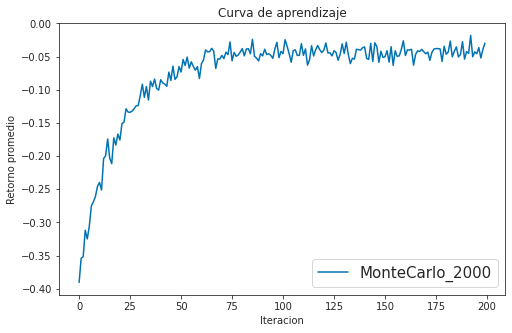

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo2000[0]), label='MonteCarlo_2000')
plt.title('Curva de aprendizaje')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

In [ ]:
class Agente():
  def __init__(self, dim_estado=(1000,1000,2), dim_accion=(2,)):    
    self.funcion_q = np.zeros(dim_estado+dim_accion) # Funcion de valor Q
    self.n_acciones = dim_accion[0]

  '''
  Metodo 1:
  Este metodo transforma la mano del jugador y la carta del dealer
  a nuestra representacion de estado. 
  Argumentos:
    - estado: tupla donde el primer elemento es una lista de cartas, 
              correspondientes a la mano del jugador, y donde el segundo 
              elemento es la carta visible del dealer
  Salida:
    - estado transformado: tupla de 3 elementos (s_0, s_1, s_2), donde:
              s_0:  indical el puntaje del jugador. Es un numero de 0 a 9, que 
                    corresponde a una suma de 12 a 21, en el mismo orden.
              s_1:  indica la mano del dealer. Es un numero de 0 a 9, que corresponde
                    al valor de la carta del dealer entre 1 y 10, en el mismo orden.
              s_2:  indica si el as es utilizable. Es un número entre 0 y 1, que
                    corresponde a si el As se puede o no utilizar como 11.                
  '''
  def transformar_estado(self, estado):
    suma_mano, puntaje_dealer, as_utilizable = state2code(estado)
    puntaje = suma_mano + 10*as_utilizable      
    if puntaje < 12:
      s_0 = s_1 = s_2 = None
    else:      
      s_0 = int(puntaje-12)        
      s_1 = int(puntaje_dealer-1)  
      s_2 = int(as_utilizable)
    estado_transformado = (s_0, s_1, s_2)   
    return estado_transformado


  '''
  Metodo 2:
  Este metodo genera una accion para sumas entre 12 y 21, siguiendo una politica
  epsilon-suave.
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - epsilon:  valor entre 0 y 1, que corresponde al factor de exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def generar_accion_con_politica_epsilon_suave(self, estado_transformado, epsilon):
    s_0, s_1, s_2 = estado_transformado
    valores_q = self.funcion_q[s_0, s_1, s_2, :]
    if np.random.rand() > epsilon: # TODO
      acciones_posibles = valores_q.argmax()
      if isinstance(acciones_posibles, np.int64):
        accion = acciones_posibles
      else:
        accion = random.choice(acciones_posibles)
    else:
      accion = np.random.randint(0, high=self.n_acciones) # TODO
    return accion
  

  '''
  Metodo 3:
  Este metodo selecciona una accion para cualquier estado.
  Argumentos: 
    - estado:   tupla donde el primer elemento es una lista de cartas, 
                correspondientes a la mano del jugador, y donde el segundo 
                elemento es la carta visible del dealer
    - epsilon:  valor real positivo entre 0 y 1, que corresponde al factor de 
                exploracion
  Salidas: 
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
  '''
  def seleccionar_accion(self, estado, epsilon):
    estado_transformado = self.transformar_estado(estado)
    suma_menor_12 = estado_transformado[0] is not None
    if suma_menor_12:
      accion = self.generar_accion_con_politica_epsilon_suave(estado_transformado, epsilon) # TODO
    else:
      accion = 1
    return accion, estado_transformado

  
  '''
  Metodo 4:
  Este metodo actualiza los valores de la funcion q para una pareja (estado-accion),
  adicionandole una cantidad específica 
  Argumentos: 
    - estado_transformado:   tupla con puntaje, carta del dealer, y bit de as utilizable
    - accion:   bit, 0 para plantarse y 1 para pedir una nueva carta
    - cambio:   valor real que determina que tanto cambia la funcion q
    - alpha:    valor real positivo entre 0 y 1, que corresponde a la tasa de aprendizaje
  '''
  def actualizar_funcion_q(self, estado_transformado, accion, cambio, alpha):
    indice_pareja_estado_accion = estado_transformado + (accion,)
    self.funcion_q[indice_pareja_estado_accion] += alpha * cambio

In [ ]:
mano_inicial = juego.reset()
agente = Agente()
accion, estado_transformado = agente.seleccionar_accion(mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Estado: ', estado_transformado)
print('Accion tomada: '+str(accion))

Mano:  [[('9', 'spades'), ('A', 'hearts')], ('9', 'hearts')]
Estado:  (8, 8, 1)
Accion tomada: 0


In [ ]:
def dar_paso(juego, agente, estado, epsilon):
  # El agente selecciona una accion
  accion, estado_transformado = agente.seleccionar_accion(estado, epsilon)# TODO

  # El agente actua en el ambiente y recibe la informacion del nuevo estado,
  # la recompensa y la señal de juego terminado
  _, siguiente_estado, recompensa, juego_terminado = juego.step(accion) # TODO
  # Se crea una lista con la informacion del paso dado
  paso = [estado_transformado, accion, recompensa, juego_terminado]
          
  return paso, siguiente_estado.copy(), juego_terminado 

In [ ]:
mano_inicial = juego.reset()
paso, siguiente_mano, juego_terminado = dar_paso(juego, agente, mano_inicial, epsilon=0.5)
print('Mano: ', mano_inicial)
print('Siguiente mano: ', siguiente_mano)
print('Juego terminado: ', juego_terminado)

Mano:  [[('Q', 'clubs'), ('K', 'diamonds')], ('7', 'diamonds')]
Siguiente mano:  [[('Q', 'clubs'), ('K', 'diamonds')], [('2', 'clubs'), ('8', 'diamonds'), ('7', 'diamonds'), ('A', 'spades')]]
Juego terminado:  True


In [ ]:
def generar_trayectoria(juego, agente, epsilon):
  juego_terminado = False    
  trayectoria = []
  estado = juego.reset()

  # Ciclo que genera una trayectoria. En este caso, corresponde a un juego 
  # completo de Blackjack. 
  while not juego_terminado:   
    # Se da un paso
    paso, siguiente_estado, juego_terminado = dar_paso(juego, agente, estado, epsilon) # TODO

    # Se agrega el paso a la trayectoria
    trayectoria.append(paso)    

    # Se actualiza la información del estado  
    estado = siguiente_estado.copy()

  return trayectoria  

In [ ]:
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Trayectoria:")
print(trayectoria)

Trayectoria:
[[(8, 5, 0), 1, -1.0, True]]


In [ ]:
def actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha, beta):
    # Se extrae el ultimo paso de la trayectoria que no ha sido incluido
    estado, accion, recompensa, juego_terminado = paso

    # Se actualiza el retorno como la suma de la recompensa mas el acumulado futuro
    retorno = recompensa+beta*retorno # TODO

    # Se actualiza la funcion q del agente si la suma es mayor a 12
    suma_mayor_12 = estado[0] is not None
    if suma_mayor_12:
      indice_estado_accion = estado + (accion,) 
      cambio_funcion_q = retorno - agente.funcion_q[indice_estado_accion]       
      agente.actualizar_funcion_q(estado, accion, cambio_funcion_q, alpha)
    
    return retorno

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = 0.0
paso = trayectoria[-1]
print("Retorno (antes de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
retorno = actualizar_retorno_y_funcion_q_con_paso(agente, paso, retorno, alpha=0.1, beta=1.0)
print("Retorno (despues de la actualizacion): ", retorno)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Retorno (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Retorno (despues de la actualizacion):  -1.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


In [ ]:
def actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta):
    # Inicializamos el retorno
    retorno = 0

    # Recorremos la trayectoria desde el final hasta el comienzo para estimar el
    # retorno para cada pareja estado-accion
    for indice_ultimo_paso in range(len(trayectoria)-1,-1,-1):
      # Obtenemos un paso de la trayectoria
      ultimo_paso = trayectoria[indice_ultimo_paso]

      # Actalizamos el retorno para el paso y el valor q correspondiente
      retorno = actualizar_retorno_y_funcion_q_con_paso(agente, ultimo_paso, retorno, alpha, beta) # TODO

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
print("Valor absoluto máximo en la función q (antes de la actualizacion): ", np.absolute(agente.funcion_q).max())
actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha=0.1, beta=1.0)
print("Valor absoluto máximo en la función q (despues de la actualizacion): ", np.absolute(agente.funcion_q).max())

Valor absoluto máximo en la función q (antes de la actualizacion):  0.0
Valor absoluto máximo en la función q (despues de la actualizacion):  0.1


In [ ]:
def entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios, 
                    imprimir=False, imprimir_cada_ep=5000):  
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO
    
    # Actualizamos la funcion q
    actualizar_funcion_q_con_trayectoria(agente, trayectoria, alpha, beta) # TODO  
      
    if imprimir and ((episodio+1) % imprimir_cada_ep) == 0:
      print('Episodio: ' + str(episodio+1))

In [ ]:
def calcular_retorno_trayectoria(trayectoria, beta):
  # Inicializamos el valor del retorno
  retorno = 0.0

  # Iteramos, paso por paso, y vamos sumando la recompensa de cada paso,
  # teniendo en cuenta el factor de descuento
  for t, paso in enumerate(trayectoria):
    # Obtenemos la recompensa
    recompensa = paso[2]

    # Actualizamos el retorno
    retorno += (beta**t) * recompensa # TODO
    
  return retorno

In [ ]:
agente = Agente()
trayectoria = generar_trayectoria(juego, agente, epsilon=0.5)
retorno = calcular_retorno_trayectoria(trayectoria, beta=1.0)
print("Trayectoria: ", trayectoria)
print("Retorno: ", retorno)

Trayectoria:  [[(None, None, None), 1, 0.0, False], [(None, None, None), 1, 0.0, False], [(2, 9, 0), 0, -1.0, True]]
Retorno:  -1.0


In [ ]:
def evaluar_agente(juego, agente, n_episodios, epsilon, beta,
                   imprimir=False, ciclo=0):
  retornos = []
  for episodio in range(0, n_episodios):
    # Generamos una trayectoria
    trayectoria = generar_trayectoria(juego, agente, epsilon) # TODO

    # Calculamos el retorno
    retorno = calcular_retorno_trayectoria(trayectoria, beta) # TODO
      
    # Añadimos el retorno a una lista de retornos
    retornos.append(retorno)
  
  # Calculamos el retorno promedio y su desviacion
  retornos = np.array(retornos)
  retorno_promedio = retornos.mean()
  desviacion_retorno = retornos.std()

  # Imprimimos el retorno si es necesario
  if imprimir:
    print(('Ciclo: ' + str(ciclo) + ', Retorno esperado: {:.3f}'.format(
        retorno_promedio) + u"\u00B1" + '{:.3f}'.format(desviacion_retorno)))
  
  return retorno_promedio, desviacion_retorno

In [ ]:
agente = Agente()
retorno_antes = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
entrenar_agente_MonteCarlo(juego, agente, alpha=0.001, beta=1.0, epsilon=1.0, n_episodios=100000)
retorno_despues = evaluar_agente(juego, agente, n_episodios=10000, epsilon=1.0, beta=1.0)
print("Retorno antes de entrenar: ", retorno_antes)
print("Retorno despues de entrenar: ", retorno_despues)

Retorno antes de entrenar:  (-0.3794, 0.8993640197383926)
Retorno despues de entrenar:  (-0.3849, 0.8981937374531176)


In [ ]:
def entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                    n_ciclos, n_episodios_ent, n_episodios_eval):
  # Se crean listas de desempeño
  retornos_media = []
  retornos_desviacion = []

  # Se ejecuta ciclo de entrenamiento y evaluacion una cantidad n_ciclos de veces
  for ciclo in range(0, n_ciclos):
    # Se entrena al agente
    entrenar_agente_MonteCarlo(juego, agente, alpha, beta, epsilon, n_episodios_ent) # TODO

    # Se evalua al agente
    G_promedio, G_desviacion = evaluar_agente(juego, agente, n_episodios_eval, epsilon, beta, imprimir=(ciclo % imprimir_cada) == 0, ciclo=ciclo+1) # TODO
                              
    
    # Guardamos el desempeño del agente
    retornos_media.append(G_promedio)
    retornos_desviacion.append(G_desviacion)

    epsilon = max(min_epsilon, epsilon * decaimiento_epsilon)

  return retornos_media, retornos_desviacion

In [ ]:
# Se especifican hiperparametros
N_episodios_ent = 10000
N_episodios_eval = 10000
N_ciclos = 200
N_acciones = 2
epsilon = 1.0
min_epsilon = 0.01
decaimiento_epsilon = 0.95
beta = 1.0
alpha = 0.001
imprimir_cada = 20

# Se crea el juego de BlackJack y un agente por cada metodo
juego = AmbienteBJ(seed=semilla)
agente = Agente()

In [ ]:
retornos_MonteCarlo2M = entrenar_agente(juego, agente, alpha, beta, epsilon, decaimiento_epsilon, 
                                      N_ciclos, N_episodios_ent, N_episodios_eval)

Ciclo: 1, Retorno esperado: -0.391±0.895
Ciclo: 21, Retorno esperado: -0.174±0.951
Ciclo: 41, Retorno esperado: -0.073±0.958
Ciclo: 61, Retorno esperado: -0.057±0.955
Ciclo: 81, Retorno esperado: -0.046±0.951
Ciclo: 101, Retorno esperado: -0.050±0.954
Ciclo: 121, Retorno esperado: -0.040±0.954
Ciclo: 141, Retorno esperado: -0.042±0.954
Ciclo: 161, Retorno esperado: -0.054±0.954
Ciclo: 181, Retorno esperado: -0.045±0.952


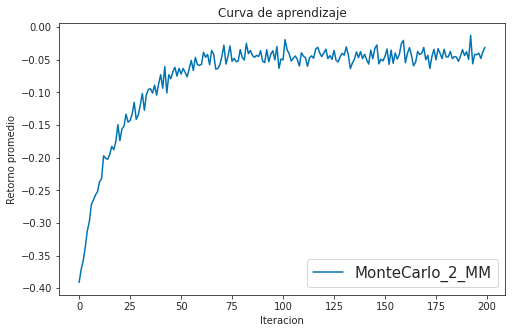

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo2M[0]), label='MonteCarlo_2_MM')
plt.title('Curva de aprendizaje')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

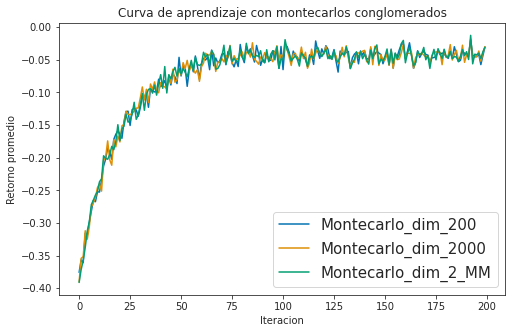

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(np.array(retornos_MonteCarlo[0]), label = 'Montecarlo_dim_200')
plt.plot(np.array(retornos_MonteCarlo2000[0]), label = 'Montecarlo_dim_2000')
plt.plot(np.array(retornos_MonteCarlo2M[0]), label = 'Montecarlo_dim_2_MM')
plt.title('Curva de aprendizaje con montecarlos conglomerados')
plt.ylabel('Retorno promedio')
plt.xlabel('Iteracion')
plt.legend(fontsize=15)
plt.show()
plt.close()

**En esta ocación, se implementaron dos versiones completas del modelo, uno con un ambiente de 2000 estados y otro con 2 millones de estados. Según la última gráfica que resume los retornos esperados, no habría una diferencia significativa de las tendencias esperadas de los retornos promedios al variar la cantidad de estados.**

**Adicionalmente, de tratarse de que el espacio de los estados sea contínuo, es recomendable utilizar el algoritmo de Diferencia Temporal Q-Learning, debido a que en este algoritmo, el agente daría un paso sin tener que considerar cuál es la futura acción que haría, y al calcular el error de la diferencia temporal, se consideraría la posible mejor futura acción para así poder estimar la función de valor.**

##Punto 4

**Claro que sí es posible utilizar el método de programación dinámica para aproximar una solución al problema del juego de BlackJack para generar la maximización de la ganancia acumulada, inicialmente porque el juego se acomoda a la Propiedad de Markov, en cuanto a que las distribuciones de probabilidades de un estado futuro dependen de la acción que se tomaría en tiempo inmediatamente presente, dado un estado presente y no se tiene en cuenta el resultado del ambiente anterior. Adicionalmente, el juego cumple con la función de recurción, en donde la función de valor se da según la suma entre la recompensa actual y el valor esperado de la  misma función, dando cumplimiento también a la Ecuación de Bellman. De esta manera,  el problema se podría resolver por medio de la generación de matrices con valores arbitrarios entre estados y acciones, haciendo asignaciones de Bellman de manera reiterativa hasta conseguir la convergencia entre los valores de la función de valor dada una cierta política.**